In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fadqash","key":"78aea5159045ef05043191754847a2d3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c bird-genus-multi-class-image-classification

 66% 117M/177M [00:00<00:00, 1.19GB/s]
100% 177M/177M [00:00<00:00, 879MB/s] 


In [ ]:
!mkdir -p dataset
!unzip -q bird-genus-multi-class-image-classification.zip -d dataset

In [ ]:
## Data Loading & Understanding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import seaborn as sns

## Data EDA & Preprocessing
from tqdm import tqdm
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from albumentations.pytorch import ToTensorV2

##  Modelling
import timm
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch

## Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [ ]:
!mkdir -p model
!mkdir -p pretrained

In [ ]:
##################### Saving Prereained Models ######################

import torch
import timm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

models_to_save = [
    'efficientnet_b0',
    'mobilenetv3_large_100',
    'resnet18',
    'convnext_tiny',
    'swin_tiny_patch4_window7_224',
    'vit_base_patch16_224',
    'convnext_base',
    "densenet121",
]

for name in models_to_save:
    print(f"🔹 Downloading & saving {name}...")
    model = timm.create_model(name, pretrained=True)
    torch.save(model.state_dict(), f"pretrained/{name}_pretrained.pth")

print("✅ All models saved locally!")




🔹 Downloading & saving efficientnet_b0...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

RuntimeError: Parent directory model does not exist.

In [ ]:
device = torch.device("cuda")

## Load Dataset & Understanding

In [ ]:
train_path = "/content/dataset/train.csv"
train_img = "/content/dataset/images/train"

In [ ]:
def load_dataset(image_path="filename", labels="genus", data_dir=None, csv_path=None):
    df = pd.read_csv(csv_path)
    assert all(c in df.columns for c in [image_path, labels])

    df = df.sample(frac=1).reset_index(drop=True)
    print(f"Terdapat {len(df)} data citra dan {df[labels].nunique()} label")
    return df

df_train = load_dataset(csv_path=train_path)


Terdapat 4258 data citra dan 27 label


In [ ]:
def show_samples(df, data_dir = train_img, n_per_class=3, image_paths = "filename", labels = "genus"):
    classes = df[labels].unique()
    for cls in classes:
        subset = df[df[labels] == cls].sample(min(n_per_class, len(df[df[labels] == cls])))
        plt.figure(figsize = (n_per_class * 2, 2))
        for i, (_, row) in enumerate (subset.iterrows()):
            if data_dir is not None:
                img = Image.open(os.path.join(data_dir, row[image_paths]))
            else:
                img = Image.open(row[image_paths])
            plt.subplot(1, n_per_class, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
        plt.tight_layout
        plt.show


/tmp/ipython-input-1685574316.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (n_per_class * 2, 2))


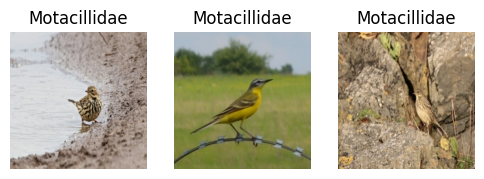

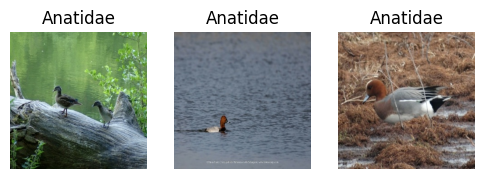

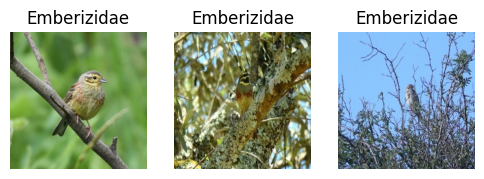

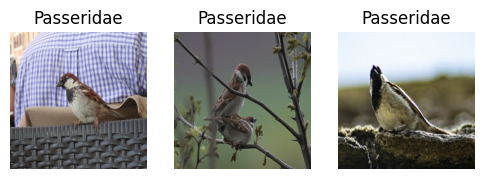

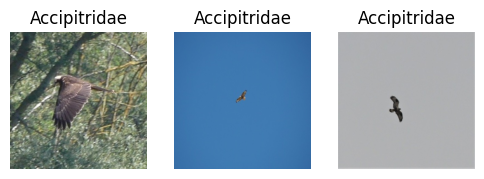

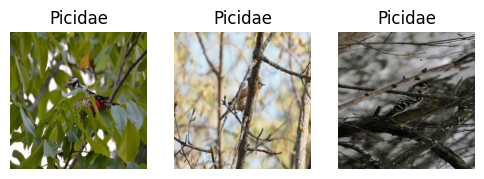

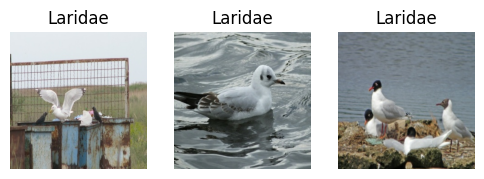

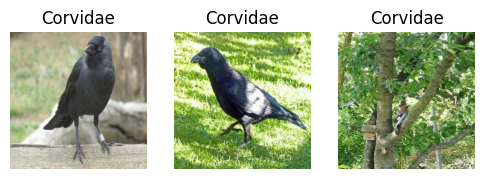

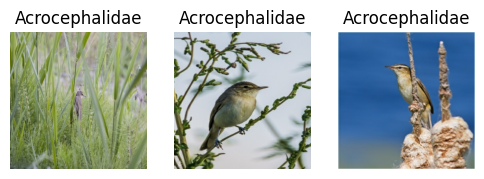

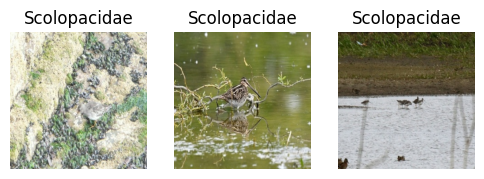

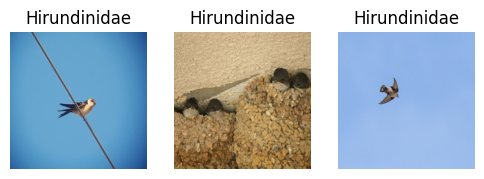

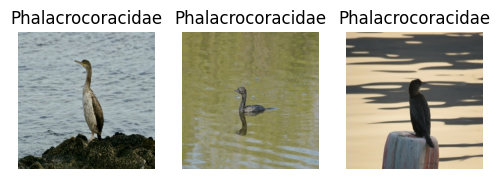

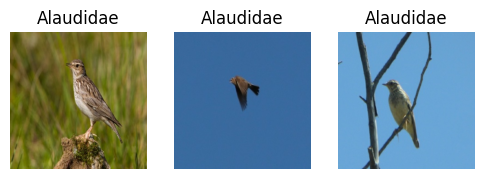

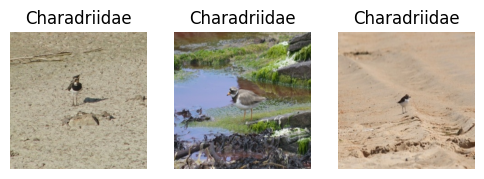

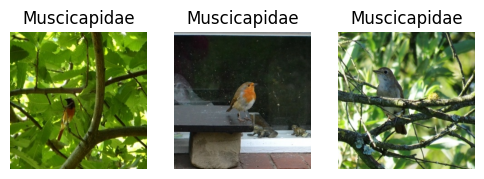

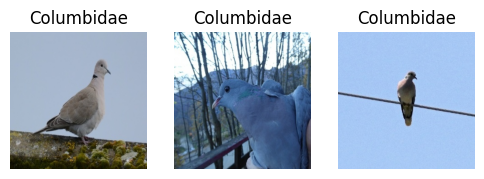

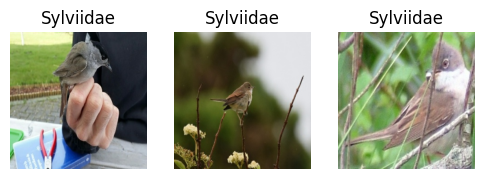

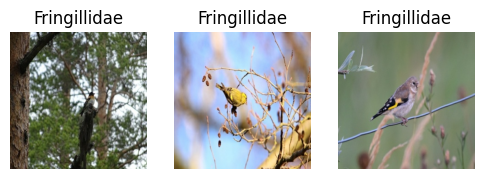

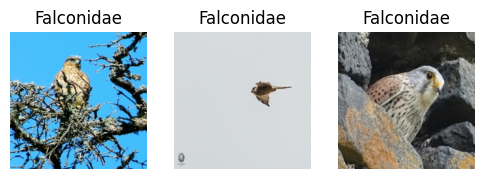

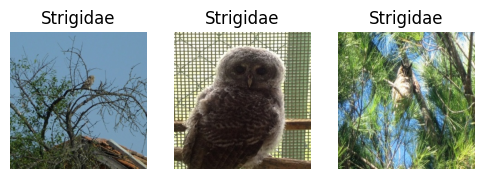

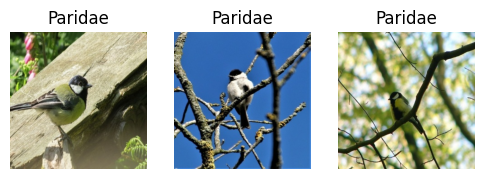

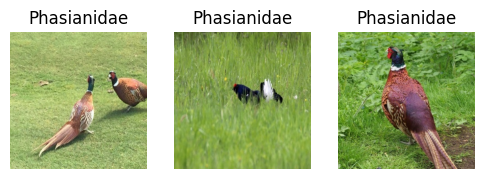

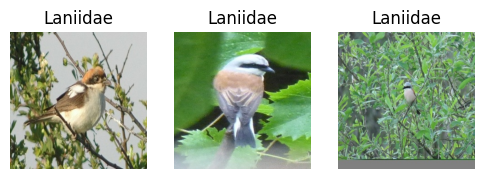

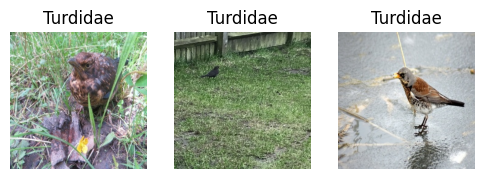

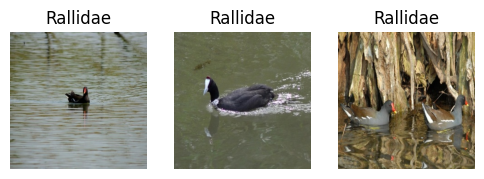

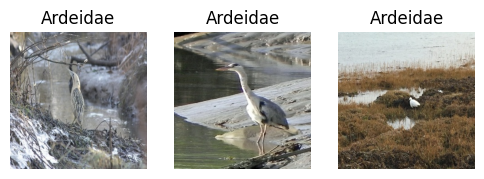

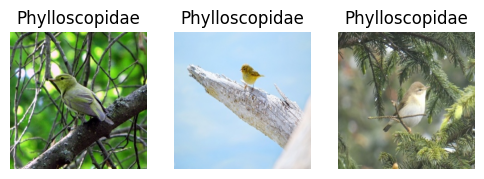

In [ ]:
show_samples(df_train, data_dir = train_img)

In [ ]:
print(df_train.head())
print("\n Class Distribution")
print(df_train['genus'].value_counts())
df_train['genus'].nunique()

     id                                  filename         genus
0  2440  9f2bc775-d683-4748-8ba5-6c669ab37771.jpg  Motacillidae
1  1357  cde8dc58-b819-4156-8b9d-081cd7ad9ea7.jpg      Anatidae
2  3380  133f5ab9-8f5b-4dd9-b94b-9a9977e79df6.jpg   Emberizidae
3  1562  dfb93fe1-9b97-46ad-b5d0-0977e162271b.jpg    Passeridae
4  3639  e1297717-8e5e-4690-8139-5bb17680bd34.jpg  Accipitridae

 Class Distribution
genus
Anatidae             507
Accipitridae         322
Laridae              319
Fringillidae         300
Muscicapidae         300
Scolopacidae         268
Corvidae             248
Motacillidae         199
Picidae              192
Emberizidae          170
Paridae              167
Sylviidae            124
Turdidae             105
Acrocephalidae        97
Columbidae            94
Charadriidae          85
Falconidae            83
Ardeidae              77
Rallidae              75
Phasianidae           74
Laniidae              74
Phylloscopidae        70
Strigidae             69
Hirundinidae  

27

## EDA

In [ ]:
width, heights, ratio = [], [], []

for path in tqdm(df_train["filename"], desc = "Analyzing image sizes"):
    try:
        with Image.open(os.path.join(train_img, path)) as img:
            w, h = img.size
            width.append(w)
            heights.append(h)
            ratio.append(w / h)
    except:
        print(f"Image {os.path.join(train_img, path)} cant be opened adding null data")
        widths.append(None)
        heights.append(None)
        ratios.append(None)
df_train["width"] = width
df_train["heights"] = heights
df_train["ratio"] = ratio

df_train[['width', 'heights', 'ratio']].head()

Analyzing image sizes: 100%|██████████| 4258/4258 [00:00<00:00, 14492.63it/s]


width  heights  ratio
0    300      300    1.0
1    300      300    1.0
2    300      300    1.0
3    300      300    1.0
4    300      300    1.0

In [ ]:
def image_stats(df, sample_size = 200, image_col="filename", data_dir = None, per_class = False, label_col = 'genus'):
    sample_df = df.sample(min(sample_size, len(df))).reset_index(drop=True)
    mean_rgb, std_rgb = [], []
    per_class_stats = {}

    for _, row in tqdm (sample_df.iterrows(), total = len(sample_df), desc="computing RGB stats"):
        path = row[image_col]
        label = row[label_col] if label_col in row else unknown
        if data_dir is not None:
            path = os.path.join(data_dir, path)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

        mean = img.mean(axis=(0, 1))
        std = img.std(axis=(0, 1))

        mean_rgb.append(mean)
        std_rgb.append(std)

        if per_class:
            if label not in per_class_stats:
                per_class_stats[label] = {"mean": [], "std": []}
            per_class_stats[label]["mean"].append(mean)
            per_class_stats[label]["std"].append(std)

    mean_rgb = np.mean(mean_rgb, axis = 0)
    std_rgb = np.mean(std_rgb, axis = 0)

    if per_class:
        for cls in per_class_stats:
            per_class_stats[cls]["mean"] = np.mean(per_class_stats[cls]["mean"], axis = 0)
            per_class_stats[cls]["std"] = np.mean(per_class_stats[cls]["std"], axis = 0)
        return mean_rgb, std_rgb, per_class_stats
    else:
        return mean_rgb, std_rgb

In [ ]:
mean_rgb, std_rgb, per_class_stats = image_stats(df_train, data_dir = train_img, per_class = True)

print(f"Global mean RGB: {mean_rgb}")
print(f"Global std RGB: {std_rgb}")
for cls, stats in per_class_stats.items():
    print(f"{cls}: Mean {stats["mean"]}, Std {stats["std"]}")

computing RGB stats: 100%|██████████| 200/200 [00:01<00:00, 142.58it/s]

Global mean RGB: [0.48876733 0.51333423 0.46724112]
Global std RGB: [0.16118703 0.16461209 0.17909617]
Corvidae: Mean [0.50536966 0.52785598 0.45236667], Std [0.19605842 0.18791656 0.19344464]
Paridae: Mean [0.52076186 0.55461514 0.52893987], Std [0.20484269 0.22705597 0.24846743]
Muscicapidae: Mean [0.47493628 0.50806065 0.42155988], Std [0.15682389 0.16269816 0.17388601]
Anatidae: Mean [0.45275649 0.47162075 0.41843222], Std [0.16172729 0.15962674 0.17176127]
Alaudidae: Mean [0.5406659  0.56627782 0.65790052], Std [0.05737028 0.06597497 0.08030736]
Laridae: Mean [0.42217476 0.44887793 0.43139962], Std [0.14864545 0.13989017 0.14915685]
Fringillidae: Mean [0.43965648 0.49296431 0.49562133], Std [0.15816589 0.16929023 0.20322188]
Turdidae: Mean [0.47812273 0.4743098  0.40554187], Std [0.15579317 0.15451748 0.15657303]
Scolopacidae: Mean [0.54586592 0.5540875  0.51789738], Std [0.14513765 0.15352772 0.17741843]
Picidae: Mean [0.53018428 0.53370931 0.4895491 ], Std [0.22936653 0.23379005

In [ ]:
## Separability test

In [ ]:
## T-Sna Test

## Preprocessing

In [ ]:
classes = df_train["genus"].value_counts().items()
minor_class = []
for cls, item in classes:
    if int(item) < 90:
        minor_class.append(cls)

In [ ]:
le = LabelEncoder()

df_train["genus"] = le.fit_transform(df_train["genus"])

In [ ]:
train_set, test_set = train_test_split(df_train, test_size = 0.2, stratify=df_train["genus"], random_state=42)


In [ ]:
minor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.49879912, 0.52950748, 0.49215817],
                        std = [0.15753651, 0.16203712, 0.17966027]),
    transforms.RandomHorizontalFlip()
])


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.49879912, 0.52950748, 0.49215817],
                        std = [0.15753651, 0.16203712, 0.17966027]),
])


# val_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize( mean = [0.49879912, 0.52950748, 0.49215817],
#                         std = [0.15753651, 0.16203712, 0.17966027]),
# ])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, df, transform, dir_path, special_label=None,  mode="train"):
        self.df = df.reset_index()
        self.transform = transform
        self.dir_path = dir_path
        self.special_label = special_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filename']
        label = self.df.loc[idx, 'genus']
        image = Image.open(os.path.join(self.dir_path, img_path)).convert("RGB")
        if self.special_label is not None :
            if self.transform and label not in self.special_label:
                image = self.transform[1](image)
            else:
                image = self.transform[0](image)
        else:
                image = self.transform[0](image)
        return image, label

In [ ]:



train_data = ImageDataset(train_set, transform=[train_transform, minor_transform], dir_path = train_img, special_label = minor_class)
val_data = ImageDataset(test_set, transform=[train_transform, minor_transform], dir_path = train_img)

In [ ]:
class_counts = df['label_encoded'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = df['label_encoded'].map(lambda x: class_weights[x]).values

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

## Modelling

In [ ]:
print(device)

cuda


In [ ]:
class Trainer():
     def __init__(self, model, device, criterion, optimizer, early_stopping_patience, save_path, wscheduler=None):
         self.model = model.to(device)
         self.device = device
         self.criterion = criterion
         self.optimizer = optimizer
         self.scheduler =scheduler
         self.early_stopping_patience = early_stopping_patience
         self.save_path = save_path
         self.best_val_loss = 0.0
         self.epochs_no_improve = 0

     def train_one_epoch(self, train_loader):
            self.model.train()

            running_loss = 0.0
            correct, total = 0,0

            for images, labels in tqdm(train_loader, desc="Training", leave=False):
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

            train_acc = 100 * correct / total
            train_loss = running_loss / total

            return train_loss, train_acc

     def validate_per_epoch(self, val_loader):
            val_loss, val_correct, val_total = 0.00, 0, 0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc="Validation"):
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * images.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (preds == labels).sum().item()

            epoch_loss = val_loss/val_total
            epoch_acc = 100 * val_correct / val_total

            return epoch_loss, epoch_acc


     def fit(self, train_loader, val_loader, num_epochs):
            history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

            for epoch in range(num_epochs):
                print(f"epochs {epoch}/{num_epochs}")
                train_loss, train_acc = self.train_one_epoch(train_loader)
                val_loss, val_acc = self.validate_per_epoch(val_loader)

                history["train_loss"].append(train_loss)
                history["train_acc"].append(train_acc)
                history["val_loss"].append(val_loss)
                history["val_acc"].append(val_acc)

                print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%"
                     f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.save = f"model/model-epoch{epoch}-best.pth"
                    torch.save(self.model.state_dict(), self.save_path)
                    self.epochs_no_improve = 0
                else:
                    self.epochs_no_improve += 1
                    if self.early_stopping_patience and self.epochs_no_improve > self.early_stopping_patience:
                        self.save_path = "model/finetuned-model.pth"
                        torch.save(self.model.state_dict(), self.save_path)
                        print(f"Early stopped latest model saved {self.save_path}")




In [ ]:
class ResnetFineTune(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True, dropout=0.3):
        super(ResnetFineTune, self).__init__()

        model = timm.create_model("resnet50", pretrained = False)
        model.load_state_dict(torch.load("pretrained/resnet50-pretrained.pth"))
        self.backbone = model

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
import torch
import torch.nn as nn
import timm

class HybridFineTune(nn.Module):
    def __init__(self, num_classes, convnext_weight_path=None, freeze_backbone=True, dropout=0.3):
        super(HybridFineTune, self).__init__()

        # === EfficientNet backbone (fine-grained features) ===
        self.eff = timm.create_model('efficientnet_b0', pretrained=False, num_classes=0)
        eff_features = self.eff.num_features

        # === ConvNeXt backbone (general features) ===
        self.convnext = timm.create_model('convnext_tiny', pretrained=False, num_classes=0)
        if convnext_weight_path is not None:
            print(f"Loading ConvNeXt weights from {convnext_weight_path} ...")
            state_dict = torch.load(convnext_weight_path, map_location='cpu')
            self.convnext.load_state_dict(state_dict, strict=False)
        conv_features = self.convnext.num_features

        # === Freeze backbone (optional) ===
        if freeze_backbone:
            for p in self.eff.parameters():
                p.requires_grad = False
            for p in self.convnext.parameters():
                p.requires_grad = False

        # === Fusion layer ===
        total_features = eff_features + conv_features
        self.classifier = nn.Sequential(
            nn.Linear(total_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        eff_out = self.eff(x)
        conv_out = self.convnext(x)

        # Concatenate kedua feature
        combined = torch.cat((eff_out, conv_out), dim=1)
        out = self.classifier(combined)
        return out


In [ ]:
model = ResnetFineTune(num_classes = int(df_train["genus"].nunique()), freeze_backbone= False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
trainer = Trainer(
    model = model,
    device = device,
    criterion = criterion,
    optimizer = optimizer,
    early_stopping_patience = 10,
    save_path = "model/finetuned-resnet.pth"
)

In [ ]:
history = trainer.fit(train_loader, val_loader, num_epochs = 50)

epochs 0/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


Train Loss: 3.1895, Train Accuracy: 11.36%
Validation Loss: 3.0460, Validation Accuracy: 15.85%
epochs 1/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Train Loss: 2.9076, Train Accuracy: 15.94%
Validation Loss: 2.7894, Validation Accuracy: 18.66%
epochs 2/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


Train Loss: 2.6455, Train Accuracy: 23.46%
Validation Loss: 2.5723, Validation Accuracy: 29.58%
epochs 3/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


Train Loss: 2.3533, Train Accuracy: 37.55%
Validation Loss: 2.3052, Validation Accuracy: 38.15%
epochs 4/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


Train Loss: 2.0240, Train Accuracy: 46.04%
Validation Loss: 2.0874, Validation Accuracy: 43.08%
epochs 5/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Train Loss: 1.7265, Train Accuracy: 51.47%
Validation Loss: 1.9013, Validation Accuracy: 47.77%
epochs 6/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


Train Loss: 1.4555, Train Accuracy: 58.13%
Validation Loss: 1.7263, Validation Accuracy: 50.35%
epochs 7/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.53it/s]


Train Loss: 1.2068, Train Accuracy: 65.33%
Validation Loss: 1.6119, Validation Accuracy: 53.52%
epochs 8/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Train Loss: 0.9761, Train Accuracy: 72.99%
Validation Loss: 1.5265, Validation Accuracy: 55.99%
epochs 9/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


Train Loss: 0.7807, Train Accuracy: 79.65%
Validation Loss: 1.4693, Validation Accuracy: 58.22%
epochs 10/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


Train Loss: 0.6170, Train Accuracy: 85.55%
Validation Loss: 1.3993, Validation Accuracy: 60.21%
Early stopped latest model saved model/finetuned-model.pth
epochs 11/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


Train Loss: 0.4794, Train Accuracy: 89.90%
Validation Loss: 1.4188, Validation Accuracy: 60.21%
Early stopped latest model saved model/finetuned-model.pth
epochs 12/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Train Loss: 0.3815, Train Accuracy: 92.63%
Validation Loss: 1.4491, Validation Accuracy: 58.92%
Early stopped latest model saved model/finetuned-model.pth
epochs 13/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Train Loss: 0.2949, Train Accuracy: 95.42%
Validation Loss: 1.3844, Validation Accuracy: 60.80%
Early stopped latest model saved model/finetuned-model.pth
epochs 14/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


Train Loss: 0.2355, Train Accuracy: 96.45%
Validation Loss: 1.3994, Validation Accuracy: 61.03%
Early stopped latest model saved model/finetuned-model.pth
epochs 15/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]


Train Loss: 0.1819, Train Accuracy: 97.48%
Validation Loss: 1.4412, Validation Accuracy: 60.68%
Early stopped latest model saved model/finetuned-model.pth
epochs 16/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


Train Loss: 0.1417, Train Accuracy: 98.30%
Validation Loss: 1.4759, Validation Accuracy: 60.80%
Early stopped latest model saved model/finetuned-model.pth
epochs 17/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Train Loss: 0.1140, Train Accuracy: 98.74%
Validation Loss: 1.4395, Validation Accuracy: 61.15%
Early stopped latest model saved model/finetuned-model.pth
epochs 18/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


Train Loss: 0.0929, Train Accuracy: 98.97%
Validation Loss: 1.4170, Validation Accuracy: 62.21%
Early stopped latest model saved model/finetuned-model.pth
epochs 19/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


Train Loss: 0.0863, Train Accuracy: 99.09%
Validation Loss: 1.4933, Validation Accuracy: 62.09%
Early stopped latest model saved model/finetuned-model.pth
epochs 20/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Train Loss: 0.0663, Train Accuracy: 99.53%
Validation Loss: 1.4751, Validation Accuracy: 62.91%
Early stopped latest model saved model/finetuned-model.pth
epochs 21/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


Train Loss: 0.0508, Train Accuracy: 99.62%
Validation Loss: 1.4649, Validation Accuracy: 62.79%
Early stopped latest model saved model/finetuned-model.pth
epochs 22/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


Train Loss: 0.0450, Train Accuracy: 99.68%
Validation Loss: 1.4921, Validation Accuracy: 62.56%
Early stopped latest model saved model/finetuned-model.pth
epochs 23/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


Train Loss: 0.0384, Train Accuracy: 99.59%
Validation Loss: 1.5214, Validation Accuracy: 62.56%
Early stopped latest model saved model/finetuned-model.pth
epochs 24/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


Train Loss: 0.0346, Train Accuracy: 99.74%
Validation Loss: 1.5540, Validation Accuracy: 61.97%
Early stopped latest model saved model/finetuned-model.pth
epochs 25/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


Train Loss: 0.0275, Train Accuracy: 99.79%
Validation Loss: 1.5207, Validation Accuracy: 63.26%
Early stopped latest model saved model/finetuned-model.pth
epochs 26/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.53it/s]


Train Loss: 0.0229, Train Accuracy: 99.85%
Validation Loss: 1.5358, Validation Accuracy: 63.73%
Early stopped latest model saved model/finetuned-model.pth
epochs 27/50


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Train Loss: 0.0196, Train Accuracy: 99.97%
Validation Loss: 1.5380, Validation Accuracy: 62.56%
Early stopped latest model saved model/finetuned-model.pth
epochs 28/50


KeyboardInterrupt: 

In [ ]:
# Path ke weight ConvNeXt lokal
convnext_weights = r"pretrained\convnext_tiny_pretrained.pth"

model = HybridFineTune(
    num_classes = int(df_train["genus"].nunique()),
    convnext_weight_path=convnext_weights,
    freeze_backbone=True,
    dropout=0.4
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# x = torch.randn(4, 3, 224, 224)
# out = model(x)
# print("Output shape:", out.shape)


In [ ]:
trainer = Trainer(
    model = model,
    device = device,
    criterion = criterion,
    optimizer = optimizer,
    early_stopping_patience = 10,
    save_path = "model/finetuned-hybrid.pth"
)

In [ ]:
history = trainer.fit(train_loader, val_loader, num_epochs = 50)

######

## Testing & Evaluation

In [ ]:
num_classes =  int(df_train["genus"].nunique())
model = ResnetFineTune(num_classes=num_classes, freeze_backbone=False)

checkpoint = torch.load("model/finetuned-model.pth", map_location="cpu")
model.load_state_dict(checkpoint)

print("Model berhasil dimuat dan siap digunakan!")


Model berhasil dimuat dan siap digunakan!


In [ ]:
test_image = "dataset/images/test"
test_csv = "dataset/test.csv"

test_df = pd.read_csv(test_csv)

class TestDataset(Dataset):
    def __init__(self, df, transform, dir_path):
        self.df = df.reset_index()
        self.transform = transform
        self.dir_path = dir_path


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filename']
        image = Image.open(os.path.join(self.dir_path, img_path)).convert("RGB")
        image = self.transform(image)
        return image

In [ ]:
test_data = TestDataset(test_df, transform = train_transform, dir_path = test_image)

In [ ]:
test_loader = DataLoader(test_data)

In [ ]:
pred = []

model.to(device)
with torch.no_grad():
    for images in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        pred.append(int(preds.item()))




Testing: 100%|██████████| 540/540 [00:06<00:00, 83.56it/s]


In [ ]:
len(pred)

540

In [ ]:
test_df["genus"] = le.inverse_transform(pred)

test_df[["id", "genus"]].to_csv("result_pred.csv",  index=False)

In [ ]:
!kaggle competitions submit -c bird-genus-multi-class-image-classification -f result_pred.csv -m "Message"

100% 8.36k/8.36k [00:00<00:00, 23.7kB/s]
Successfully submitted to Bird Genus Multi-class Image Classification